In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

In [2]:
eps = 1e-10

# Все функции

## Вспомогательные функции

In [3]:
def round_up_if_needed(x):
    return x if x == int(x) else math.ceil(x)

In [4]:
def inter(x1, t1, t2):
    x_min, x_max = min(t1[0], t2[0]), max(t1[0], t2[0])
    if x1 < x_min or x1 > x_max:
        return None

    if t1[0] == t2[0]:
        return None

    y = t1[1] + (x1 - t1[0]) * (t2[1] - t1[1]) / (t2[0] - t1[0])

    if x1 == t1[0]:
      return (t1[0], t1[1])

    if x1 == t2[0]:
      return (t2[0], t2[1])

    return (x1, y)

In [5]:
def inter_T(X, P):
  T = []
  for x1 in X:
    for i in range(len(P)):
        t1, t2 = P[i], P[(i + 1) % len(P)]
        point = inter(x1, t1, t2)
        if point and point not in T:
            T.append(point)
  return T

In [6]:
def ins(poi, P):
    count = 0
    count2 = 0
    for i in range(len(P)):
        t1, t2 = P[i], P[(i + 1) % len(P)]
        p = inter(poi[0], t1, t2)
        if p and p[1] >= poi[1]:
            count += 1
        if p and p[1] <= poi[1]:
          count2 += 1
    return count % 2 == 1 or count2 % 2 == 1

In [7]:
def seg_x(T, P):
    seg = []
    points = []

    for t1 in T:
        for t2 in T:
            temp = [((t1[1] < p[1] < t2[1]) or (t2[1] < p[1] < t1[1])) and (t1[0] == p[0]) and (t2[0] == p[0]) for p in T]
            temp_filtered = [p if cond else False for p, cond in zip(T, temp)]
            # if t1[0] == t2[0] and t1[1] != t2[1]:
            #   print(t1, t2, temp_filtered)
            if t1[0] == t2[0] and temp.count(True) < 1:
                poi = np.zeros(2)
                poi[0] = t1[0]
                py_min, py_max = min(t1[1], t2[1]), max(t1[1], t2[1])
                poi[1] = (py_max + py_min) / 2

                if ins(poi, P):
                    seg.append([[t1[0], py_min], [t1[0], py_max]])


                # print(poi)
                # print(P)
                if any(np.all(poi == p) for p in P):
                    # print(poi)
                    # print(P)
                    points.append(poi)

    return seg, points

In [8]:
def projections(X, P):
  proj = []
  for p in P:
    if p[0] in X:
      proj.append(p)
      proj.append(p)
    j = None
    for i in range(len(X) - 1):
      if X[i] < p[0] < X[i + 1]:
        j = i

    if j != None:
      proj.append([X[j], p[1]])
      proj.append([X[j + 1], p[1]])

    # print(p, j)
  return proj

## Функция кодировки

In [9]:
def elp(P, X, K_seg, K_points, mode):
    for i in range(len(P)):
      if mode == "inv":
        t1, t2 = P[(i + 1) % len(P)], P[i]
      else:
        t1, t2 = P[i], P[(i + 1) % len(P)]
      k = None
      for j in range(len(X) - 1):
        if X[j] <= t2[0] <= X[j + 1]:
          k = j
          break
      # print(k, t2)
      if not k:
        continue
      if t2[0] not in X:
        left = inter(X[k], t1, t2)
        right = inter(X[k + 1], t1, t2)

        if left:
          if not ins([t2[0] + eps, t2[1]], P):
            if left not in P:
              K_seg.append([[left[0], min(t2[1], left[1])], [left[0], max(t2[1], left[1])]])
              # print("left, t2, t1,", left, t2, t1, [[left[0], min(t2[1], left[1])], [left[0], max(t2[1], left[1])]])

              K_points.append([X[k + 1], t2[1]])

        if right:
          if not ins([t2[0] - eps, t2[1]], P):
            if right not in P:
              K_seg.append([[right[0], min(t2[1], right[1])], [right[0], max(t2[1], right[1])]])
              # print("right, t2, t1", right, t2, t1, [[right[0], min(t2[1], right[1])], [right[0], max(t2[1], right[1])]])

            K_points.append([X[k], t2[1]])

        if not left and not right:
          K_seg.append([[X[k], min(t1[1], t2[1])], [X[k], max(t1[1], t2[1])]])
          K_seg.append([[X[k + 1], min(t1[1], t2[1])], [X[k + 1], max(t1[1], t2[1])]])
          # print("t1, t2, left, right, k, X[k], X[k + 1]", t1, t2, left, right, k, X[k], X[k + 1])
          # print([[X[k], min(t1[1], t2[1])], [X[k], max(t1[1], t2[1])]])
          # print([[X[k + 1], min(t1[1], t2[1])], [X[k + 1], max(t1[1], t2[1])]])


In [10]:
def merge_and_clean_segments(K_seg, K_points):
    merged_segments = []

    K_seg.sort(key=lambda seg: seg[0][1])

    for seg in K_seg:
        if not merged_segments:
            merged_segments.append(seg)
        else:
            last_seg = merged_segments[-1]
            if last_seg[0][0] == seg[0][0] and last_seg[1][1] >= seg[0][1]:
                merged_segments[-1] = [[last_seg[0][0], min(last_seg[0][1], seg[0][1])],
                                       [last_seg[1][0], max(last_seg[1][1], seg[1][1])]]
            else:
                merged_segments.append(seg)

    filtered_points = []
    for point in K_points:
        x, y = point
        inside_segment = any(seg[0][0] == x and seg[0][1] <= y <= seg[1][1] for seg in merged_segments)
        if not inside_segment and not any(np.all(point == p) for p in filtered_points):
            filtered_points.append(point)

    return merged_segments, filtered_points

In [11]:
def cod(X, P):
    T = inter_T(X, P)
    seg, points = seg_x(T, P)

    K_seg = seg
    K_points = points

    elp(P, X, K_seg, K_points, "for")
    elp(P, X, K_seg, K_points, "inv")

    K_seg, K_points = merge_and_clean_segments(K_seg, K_points)

    return K_seg, K_points

## Функция тестирования

In [12]:
def test(P, n = None, h = None):
  polygon = np.vstack([P, P[0]])

  plt.plot(polygon[:, 0], polygon[:, 1], marker='o', linestyle='-')
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Многоугольник из случайных точек")
  plt.grid(True)
  plt.show()

  x0 = 0
  # xn = max([P[i][0] for i in range(len(P))])
  # xn = 10
  xn = round_up_if_needed(max([P[i][0] for i in range(len(P))]))
  # print("xn =",  xn)
  if n:
    h = (xn - x0)/n
  else:
    n = int((xn - x0)/h)

  X = [(x0 + h*i) for i in range(n + 1)]

  T = inter_T(X, P)

  # # Отрисовка многоугольника
  # plt.plot(polygon[:, 0], polygon[:, 1], color='gray', marker='o', linestyle='-', alpha=1, zorder=1)

  # # Отрисовка вертикальной линии x = x1
  # for x1 in X:
  #   plt.axvline(x=x1, color='red', linestyle='--', alpha=0.3, zorder=2)

  # # Отрисовка точек пересечения поверх графика с увеличенным радиусом и полупрозрачностью
  # if T:
  #     T = np.array(T)
  #     plt.scatter(T[:, 0], T[:, 1], color='red', s=60, alpha=0.5, zorder=3)

  # plt.xlabel("X")
  # plt.ylabel("Y")
  # plt.title("Многоугольник с точками пересечения")
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  # # print(P)

  # seg, points = seg_x(T, P)


  # if seg:
  #   for segment in seg:
  #       plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color='blue', linestyle='-', linewidth=2, alpha=0.7)
  #   for point in points:
  #     plt.scatter(point[0], point[1], color='blue', alpha=0.7, s=60)
  #   plt.xlabel("X")
  #   plt.ylabel("Y")
  #   plt.title("Отрезки на основе точек пересечения")
  #   plt.grid(True)
  #   plt.show()

  # proj = projections(X, P)

  # # Отрисовка многоугольника
  # plt.plot(polygon[:, 0], polygon[:, 1], color='gray', marker='o', linestyle='-', alpha=1, zorder=1)

  # # Отрисовка вертикальной линии x = x1
  # for x1 in X:
  #   plt.axvline(x=x1, color='red', linestyle='--', alpha=0.3, zorder=2)

  # if proj:
  #     proj = np.array(proj)
  #     plt.scatter(proj[:, 0], proj[:, 1], color='red', s=60, alpha=0.5, zorder=3)

  # plt.xlabel("X")
  # plt.ylabel("Y")
  # plt.title("Многоугольник с точками пересечения")
  # plt.legend()
  # plt.grid(True)
  # plt.show()


  cod_seg, cod_points = cod(X, P)

  # Отрисовка многоугольника
  plt.plot(polygon[:, 0], polygon[:, 1], color='gray', marker='o', linestyle='-', alpha=1, zorder=1)

  # Отрисовка вертикальной линии x = x1
  for x1 in X:
    plt.axvline(x=x1, color='red', linestyle='--', alpha=0.3, zorder=2)

  # Отрисовка точек пересечения поверх графика с увеличенным радиусом и полупрозрачностью
  if cod_points:
      cod_points = np.array(cod_points)
      plt.scatter(cod_points[:, 0], cod_points[:, 1], color='red', s=60, alpha=0.5, zorder=3)

  if cod_seg:
    for segment in cod_seg:
        plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color='red', linestyle='-', linewidth=2, alpha=0.7)

#   print(proj)

  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Многоугольник с точками пересечения")
  plt.legend()
  plt.grid(True)
  plt.show()


# Тесты

## Тесты на случайном многоугольнике

In [13]:
m = 5

P = np.zeros((m, 2))
P = np.random.uniform(0, 10, (m, 2))

P[0][0] = 0

In [14]:
print(max([P[i][0] for i in range(len(P))]))

9.707664110348741


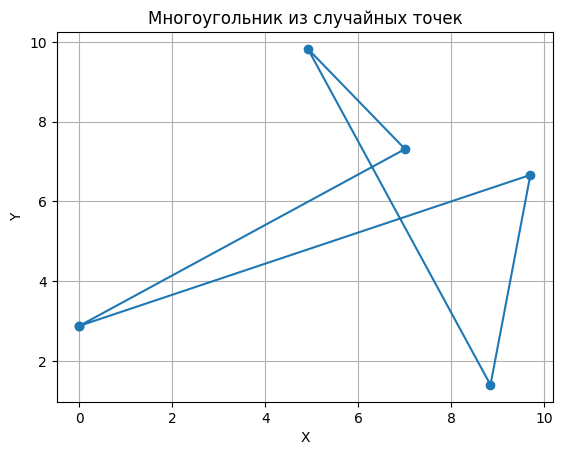

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


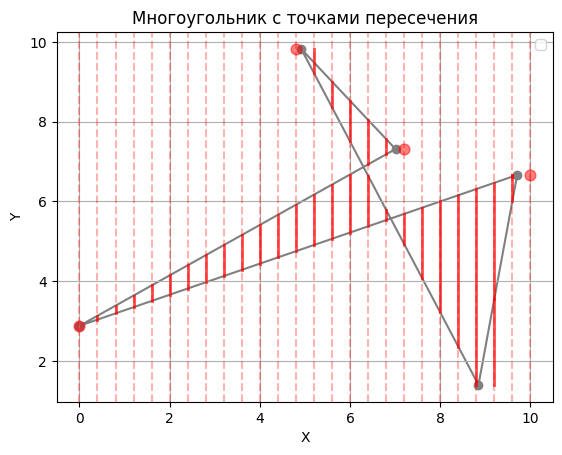

In [15]:
test(P, n = 25)

## Тесты на частных случаях

In [16]:
n = 10
h = 0.1

In [17]:
P1 = np.array([
    [0, 0],
    [1, 0],
    [1, 1],
    [0, 1]
])

P1.astype(float)

array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.]])

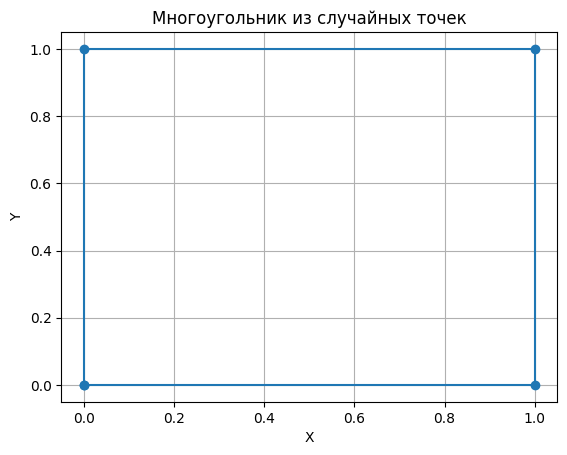

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


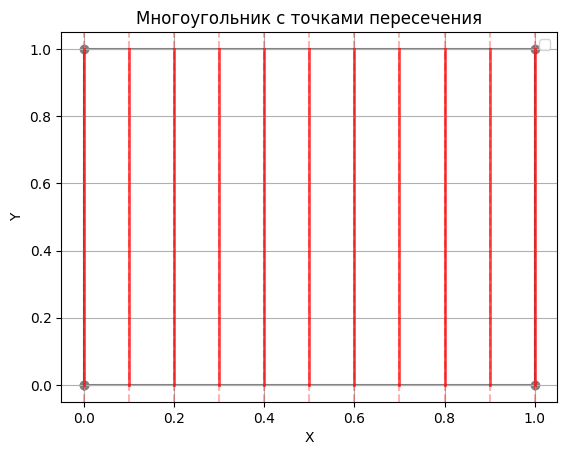

In [18]:
test(P1, n = n)

In [19]:
P2 = np.array([
    [0, 0],
    [2, 1],
    [1, 2],
    [2, 3],
    [0, 4],
    [3, 4],
    [3, 0]
])

P2.astype(float)

array([[0., 0.],
       [2., 1.],
       [1., 2.],
       [2., 3.],
       [0., 4.],
       [3., 4.],
       [3., 0.]])

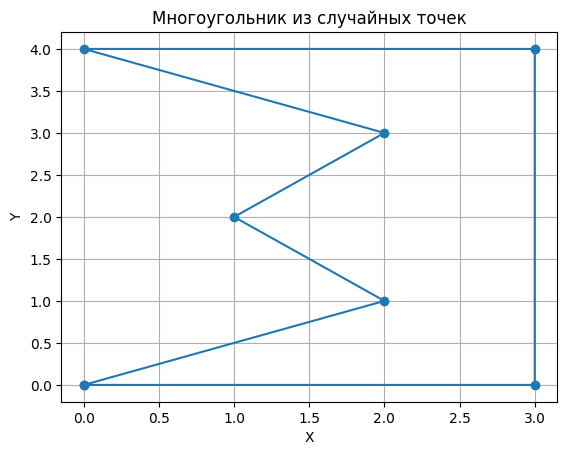

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


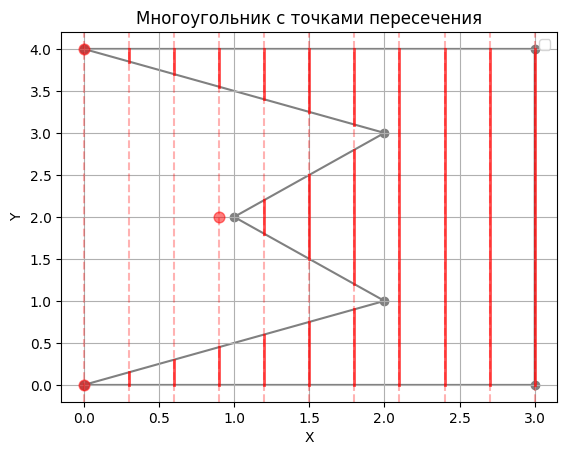

In [20]:
test(P2, h = 0.3)

In [21]:
P3 = np.array([
    [0, 1],
    [2, 1.5],
    [1, 2],
    [2, 2.5],
    [0, 3],
    [4, 4],
    [3, 0]
])

P3.astype(float)

array([[0. , 1. ],
       [2. , 1.5],
       [1. , 2. ],
       [2. , 2.5],
       [0. , 3. ],
       [4. , 4. ],
       [3. , 0. ]])

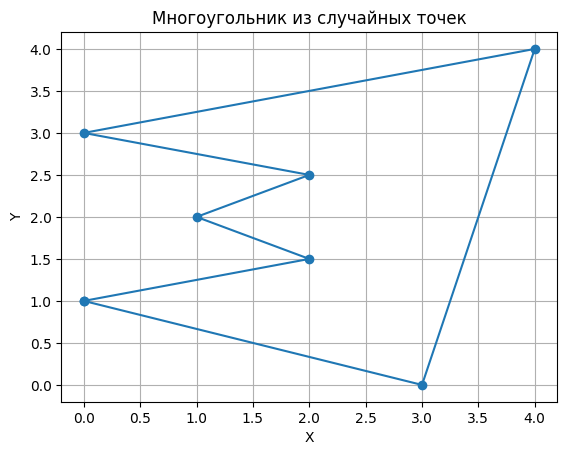

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


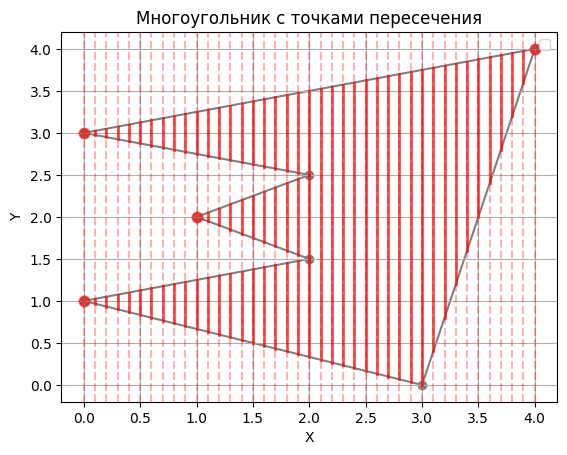

In [22]:
test(P3, h = h)

In [23]:
P4 = np.array([
    [0, 1],
    [2, 2],
    [1, 1],
    [2, 0]
])

P4.astype(float)

array([[0., 1.],
       [2., 2.],
       [1., 1.],
       [2., 0.]])

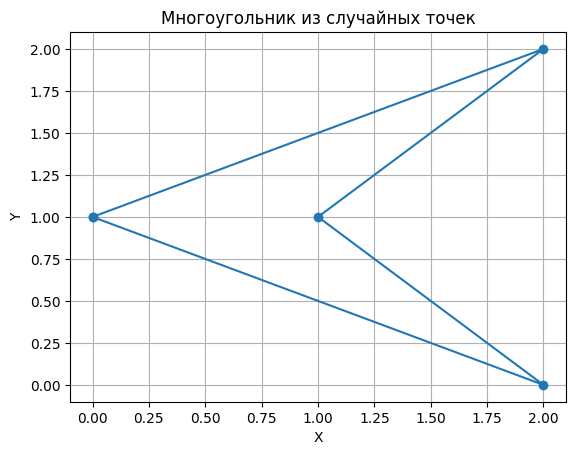

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


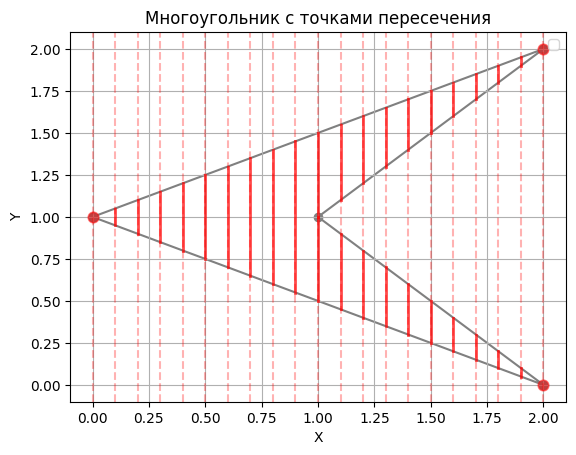

In [24]:
test(P4, h = h)

In [25]:
P5 = np.array([
    [0, 0],
    [0, 2],
    [2, 3],
    [1, 1]
])

P5.astype(float)

array([[0., 0.],
       [0., 2.],
       [2., 3.],
       [1., 1.]])

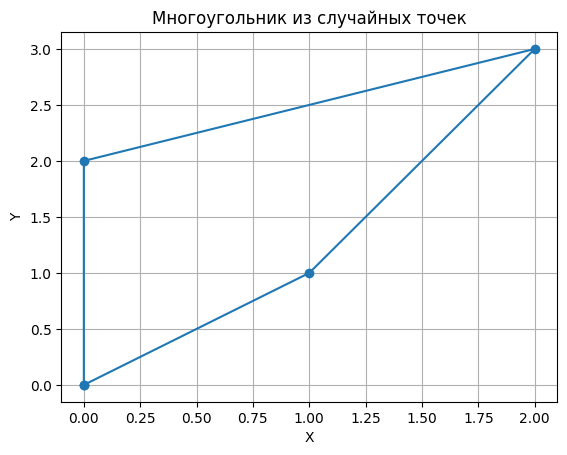

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


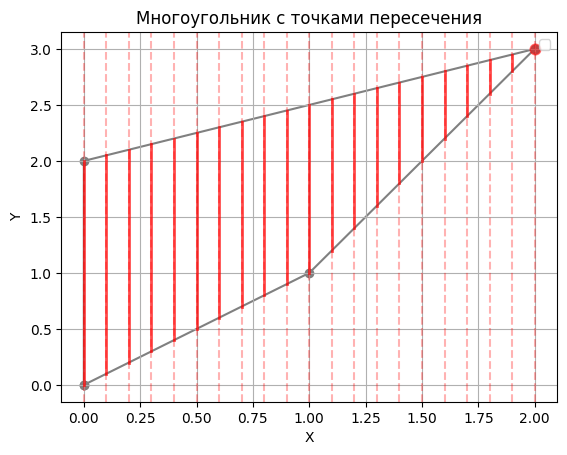

In [26]:
test(P5, h = h)

In [27]:
P6 = np.array([
    [0, 0],
    [0, 2],
    [2, 3],
    [0.5, 1.5]
])

P6.astype(float)

array([[0. , 0. ],
       [0. , 2. ],
       [2. , 3. ],
       [0.5, 1.5]])

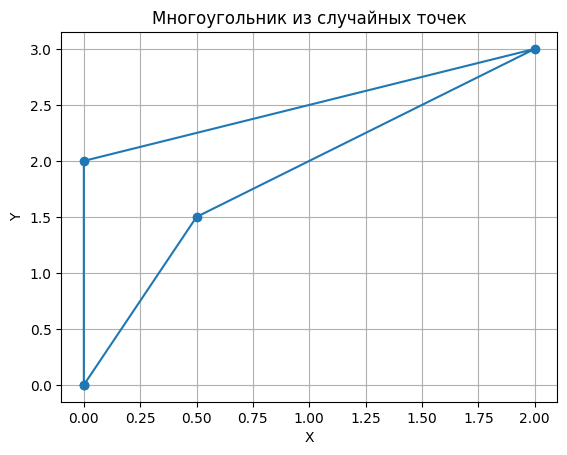

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


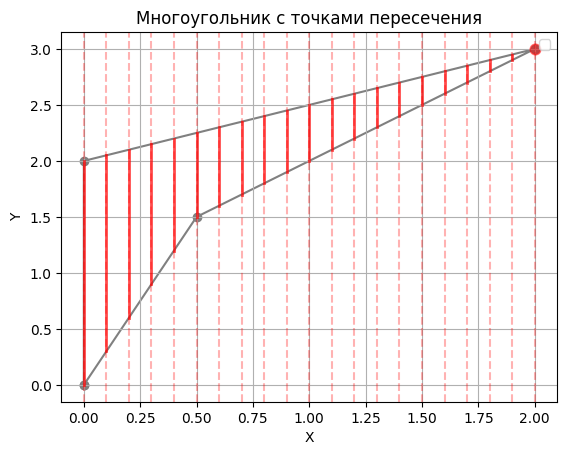

In [28]:
test(P6, h = h)

In [29]:
P7 = np.array([
    [0, 0],
    [1, 0],
    [0.5, 0.5]
])

P7.astype(float)

array([[0. , 0. ],
       [1. , 0. ],
       [0.5, 0.5]])

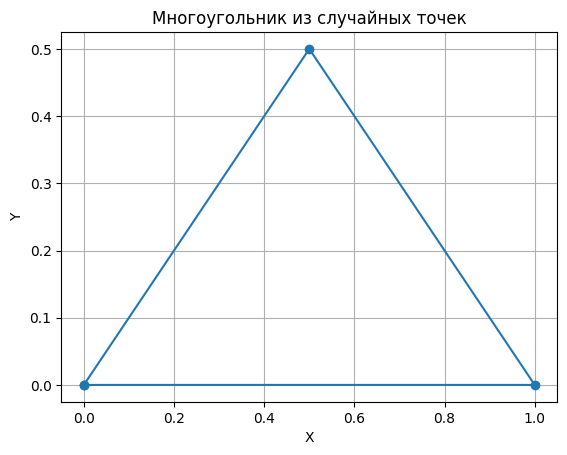

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


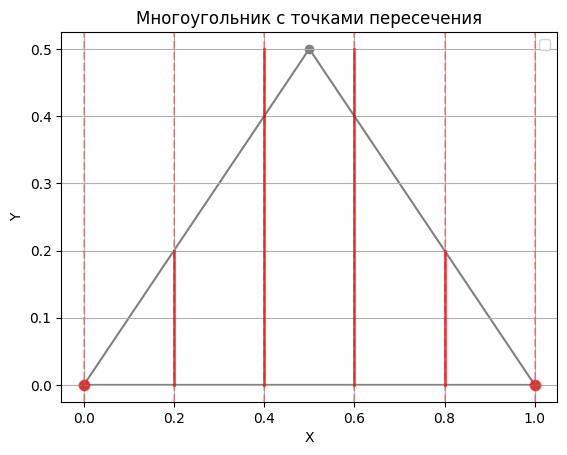

In [30]:
test(P7, h = 0.2)

In [31]:
P8 = np.array([
    [0, 0],
    [2, 0],
    [1, 1]
])

P8.astype(float)

array([[0., 0.],
       [2., 0.],
       [1., 1.]])

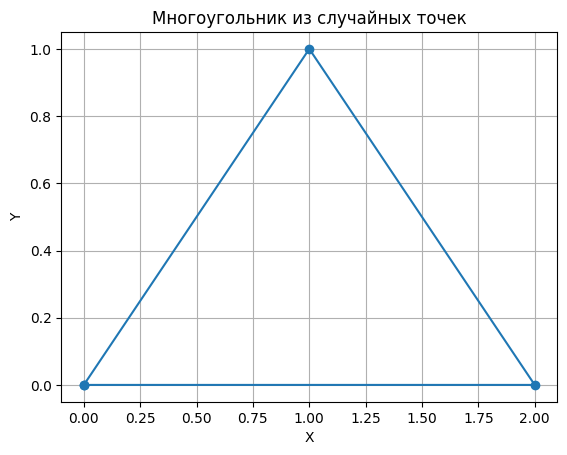

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


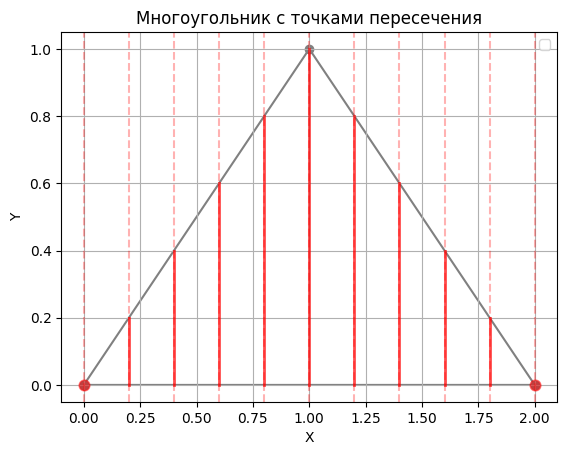

In [32]:
test(P8, h = 0.2)